In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


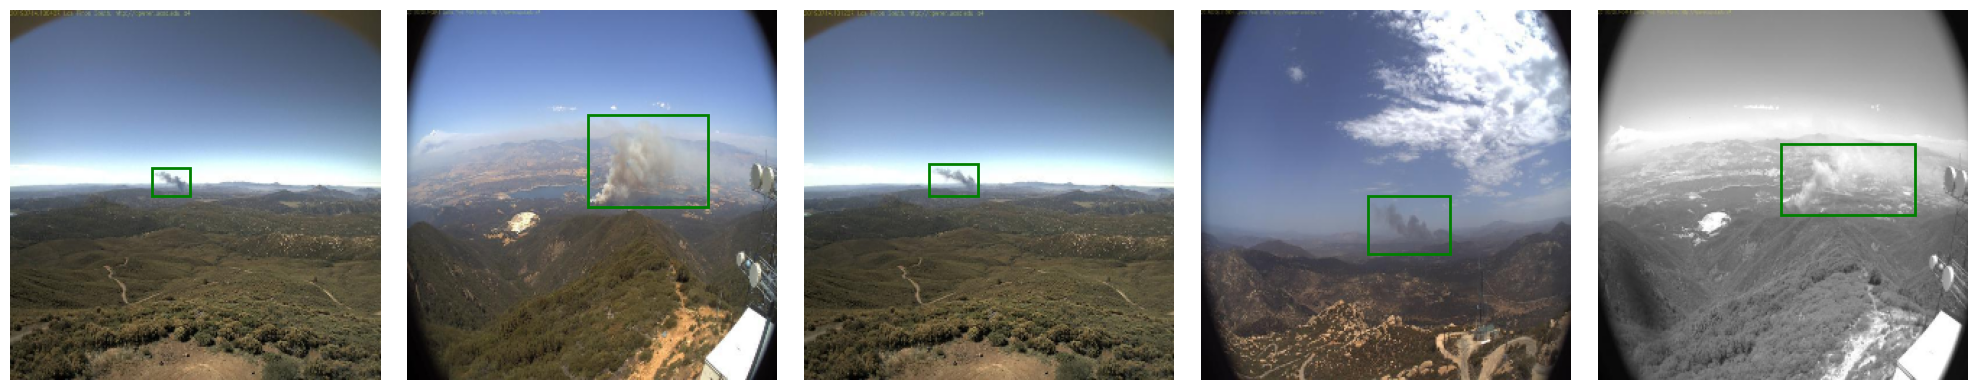

In [ ]:
import os
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

# Function to parse XML file for bounding box coordinates
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    boxes = []
    for member in root.findall('object'):
        xmin = int(member.find('bndbox/xmin').text)
        ymin = int(member.find('bndbox/ymin').text)
        xmax = int(member.find('bndbox/xmax').text)
        ymax = int(member.find('bndbox/ymax').text)
        boxes.append([xmin, ymin, xmax, ymax])
    return boxes


base_folder = '/content/drive/MyDrive/NNDL/HW3/Q2/Wildfire Smoke.v1-raw.voc'

# Function to select 5 image-XML pairs from a given folder
def select_images(folder):
    contents = os.listdir(folder)
    selected = []
    for file in contents:
        if file.endswith('.jpg') and len(selected) < 5:
            xml_file = file.replace('.jpg', '.xml')
            if xml_file in contents:
                selected.append((file, xml_file))
    return selected

# Selecting images from each folder
train_images = select_images(os.path.join(base_folder, 'train'))
test_images = select_images(os.path.join(base_folder, 'test'))
valid_images = select_images(os.path.join(base_folder, 'valid'))

# Load images and their bounding boxes from train folder for example
images = []
bboxes = []
for img_file, xml_file in train_images:  # Use train_images here
    # Load image
    image_path = os.path.join(base_folder, 'train', img_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Load bounding box
    xml_path = os.path.join(base_folder, 'train', xml_file)
    bbox = parse_xml(xml_path)

    images.append(image)
    bboxes.append(bbox)



# Resize images to a uniform size (256x256) and adjust bounding boxes
resized_images = []
resized_bboxes = []
target_size = (256, 256)

for img, box in zip(images, bboxes):
    h, w = img.shape[:2]

    # Calculate resize ratio
    x_ratio = target_size[0] / w
    y_ratio = target_size[1] / h

    # Resize image
    resized_img = cv2.resize(img, target_size)

    # Adjust bounding box coordinates
    resized_box = [[int(x * x_ratio), int(y * y_ratio), int(xmax * x_ratio), int(ymax * y_ratio)]
                   for (x, y, xmax, ymax) in box]

    resized_images.append(resized_img)
    resized_bboxes.append(resized_box)

# Display the resized images with adjusted bounding boxes
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for ax, img, box in zip(axes, resized_images, resized_bboxes):
    ax.imshow(img)
    for b in box:
        rect = plt.Rectangle((b[0], b[1]), b[2] - b[0], b[3] - b[1], fill=False, edgecolor='green', linewidth=2)
        ax.add_patch(rect)
    ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
import os
import xml.etree.ElementTree as ET
import cv2
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Function to parse XML file for bounding box coordinates
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    boxes = []
    for member in root.findall('object'):
        xmin = int(member.find('bndbox/xmin').text)
        ymin = int(member.find('bndbox/ymin').text)
        xmax = int(member.find('bndbox/xmax').text)
        ymax = int(member.find('bndbox/ymax').text)
        boxes.append([xmin, ymin, xmax, ymax])
    return boxes


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = [file for file in sorted(os.listdir(root)) if file.endswith('.jpg')]

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.imgs[idx])
        xml_path = img_path.replace('.jpg', '.xml')
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        box_list = parse_xml(xml_path)
        boxes = torch.as_tensor(box_list, dtype=torch.float32)
        num_objs = len(box_list)
        labels = torch.ones((num_objs,), dtype=torch.int64)  # Assuming one class

        target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([idx]), "area": (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]), "iscrowd": torch.zeros((num_objs,), dtype=torch.int64)}

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

def custom_collate_fn(batch):
    images, targets = zip(*batch)
    images = torch.stack([F.to_tensor(image) for image in images])
    return images, list(targets)


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim

# Define ResNet50 backbone
class ResNet50Backbone(nn.Module):
    def __init__(self):
        super(ResNet50Backbone, self).__init__()
        model = torchvision.models.vgg16(pretrained=True)
        fe = list(model.features)

        self.req_features = []
        for j, i in enumerate(fe[0:30]):
            self.req_features.append(i)

    def forward(self, x):
        # Implement the forward pass through the ResNet50 backbone
        # Return relevant feature maps for the Region Proposal Network (RPN) and RoI pooling
        for m in  self.req_features:
            x = m(x)
        return x

########################################################################################
from torchvision.models.detection.rpn import AnchorGenerator

class RPN(nn.Module):

    def __init__(self, in_channels=512, mid_channels=512, n_anchor=9):
        super(RPN, self).__init__()
        self.mid_channels = mid_channels
        self.in_channels = in_channels
        self.n_anchor = n_anchor
        self.conv1 = nn.Conv2d(self.in_channels, self.mid_channels, 3, 1, 1)
        self.reg_layer = nn.Conv2d(mid_channels, n_anchor * 4, 1, 1, 0)
        self.cls_layer = nn.Conv2d(mid_channels, n_anchor * 2, 1, 1, 0)

        # Initialization of layers
        for layer in [self.conv1, self.reg_layer, self.cls_layer]:
            layer.weight.data.normal_(0, 0.01)
            layer.bias.data.zero_()

    def forward(self, k):
        bat_num = k.shape[0]
        x = self.conv1(k)
        pred_anchor_locs = self.reg_layer(x)
        pred_cls_scores = self.cls_layer(x)

        pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(bat_num, -1, 4)
        pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()

        # Reshaping pred_cls_scores to match objectness_score's view
        objectness_score = pred_cls_scores.view(bat_num, -1, self.n_anchor, 2)[:, :, :, 1].contiguous().view(bat_num, -1)
        pred_cls_scores = pred_cls_scores.view(bat_num, -1, 2)

        return pred_anchor_locs, pred_cls_scores


class ClassifierAndBoxRegressor(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(ClassifierAndBoxRegressor, self).__init__()
        self.fc_cls = nn.Linear(in_channels, num_classes)
        self.fc_reg = nn.Linear(in_channels, num_classes * 4)  # 4 coordinates for each bounding box

    def forward(self, roi_features):
        # Flatten the pooled features
        flattened_roi_features = roi_features.view(roi_features.size(0), -1)

        # Classification head
        class_scores = self.fc_cls(flattened_roi_features)

        # Bounding box regression head
        box_deltas = self.fc_reg(flattened_roi_features)

        return class_scores, box_deltas
import torch
import torch.nn as nn

class ROIPoolingLayer(nn.Module):
    def __init__(self, pooled_height, pooled_width):
        super(ROIPoolingLayer, self).__init__()
        self.pooled_height = pooled_height
        self.pooled_width = pooled_width

    def compute_output_shape(self, input_shape):
        feature_map_shape, rois_shape = input_shape
        assert feature_map_shape[0] == rois_shape[0]
        batch_size = feature_map_shape[0]
        n_rois = rois_shape[1]
        n_channels = feature_map_shape[3]
        return (batch_size, n_rois, self.pooled_height, self.pooled_width, n_channels)

    def forward(self, x):
        feature_map, rois = x

        pooled_areas = []
        for idx in range(rois.size(1)):
            roi = rois[:, idx, :]
            pooled_area = self._pool_roi(feature_map, roi)
            pooled_areas.append(pooled_area)

        return torch.stack(pooled_areas)

    def _pool_roi(self, feature_map, roi):
        feature_map_height = feature_map.size(2)
        feature_map_width = feature_map.size(3)

        h_start = int(feature_map_height * roi[0])
        w_start = int(feature_map_width * roi[1])
        h_end = int(feature_map_height * roi[2])
        w_end = int(feature_map_width * roi[3])

        region = feature_map[:, :, h_start:h_end, w_start:w_end]

        region_height = h_end - h_start
        region_width = w_end - w_start
        h_step = region_height / self.pooled_height
        w_step = region_width / self.pooled_width

        pooled_features = []
        for i in range(self.pooled_height):
            for j in range(self.pooled_width):
                h1 = int(i * h_step)
                h2 = min(int((i + 1) * h_step), region_height)
                w1 = int(j * w_step)
                w2 = min(int((j + 1) * w_step), region_width)

                max_pool = nn.MaxPool2d((h2 - h1, w2 - w1))
                pooled_value = max_pool(region[:, :, h1:h2, w1:w2])

                pooled_features.append(pooled_value.squeeze())

        return torch.stack(pooled_features)


# Instantiate the components
resnet_backbone = ResNet50Backbone()
rpn_network = RPN(in_channels=512, mid_channels=512, n_anchor=9)
classifier_regressor = ClassifierAndBoxRegressor(in_channels=200,num_classes=2)

roipooling= ROIPoolingLayer()
full_model = nn.ModuleList([resnet_backbone, rpn_network,roipooling, classifier_regressor])

optimizer = optim.SGD(full_model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

classification_criterion = nn.CrossEntropyLoss()
regression_criterion = nn.SmoothL1Loss()



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 102MB/s]


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 0, Training Average Loss: 0.16310482947228028
Epoch: 0, Validation Average Loss: 0.11206752806901932
Epoch: 1, Training Average Loss: 0.1127790339984173
Epoch: 1, Validation Average Loss: 0.16238832473754883
Epoch: 2, Training Average Loss: 0.09304106281709301
Epoch: 2, Validation Average Loss: 0.04203573986887932
Epoch: 3, Training Average Loss: 0.08269400835441526
Epoch: 3, Validation Average Loss: 0.06668666005134583
Epoch: 4, Training Average Loss: 0.07621067641086357
Epoch: 4, Validation Average Loss: 0.06893903017044067
Epoch: 5, Training Average Loss: 0.06780988151972839
Epoch: 5, Validation Average Loss: 0.0703578069806099
Epoch: 6, Training Average Loss: 0.06204001974429964
Epoch: 6, Validation Average Loss: 0.0720585286617279
Epoch: 7, Training Average Loss: 0.05656756590618644
Epoch: 7, Validation Average Loss: 0.049769844859838486
Epoch: 8, Training Average Loss: 0.052577511248604734
Epoch: 8, Validation Average Loss: 0.06710903346538544
Epoch: 9, Training Average Lo

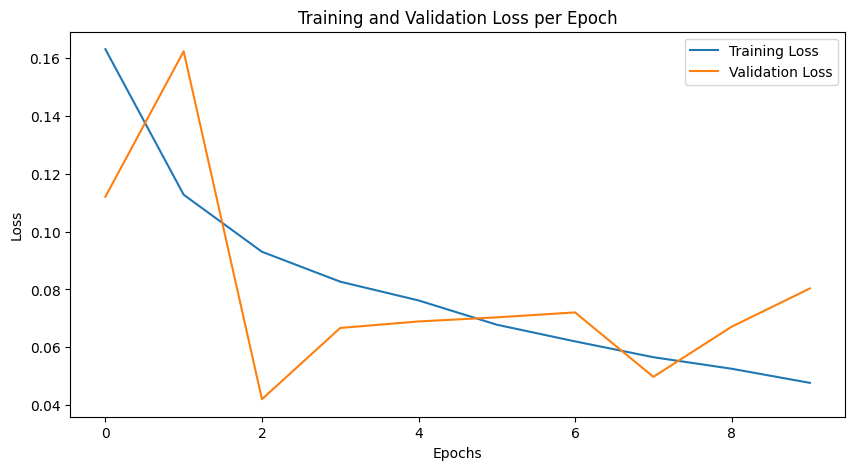

In [ ]:
import matplotlib.pyplot as plt

# Paths to your data
train_data_dir = '/content/drive/MyDrive/NNDL/HW3/Q2/Wildfire Smoke.v1-raw.voc/train'
valid_data_dir = '/content/drive/MyDrive/NNDL/HW3/Q2/Wildfire Smoke.v1-raw.voc/valid'

test_data_dir = '/content/drive/MyDrive/NNDL/HW3/Q2/Wildfire Smoke.v1-raw.voc/test'
# Create datasets and data loaders
train_dataset = CustomDataset(train_data_dir)
train_data_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=custom_collate_fn)

valid_dataset = CustomDataset(valid_data_dir)
valid_data_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers=4, collate_fn=custom_collate_fn)

test_data_dir = '/content/drive/MyDrive/NNDL/HW3/Q2/Wildfire Smoke.v1-raw.voc/test'
test_dataset = CustomDataset(test_data_dir)
test_data_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=4, collate_fn=custom_collate_fn)
# Move model to the right device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define optimizer
optimizer = torch.optim.SGD(params=[p for p in model.parameters() if p.requires_grad], lr=0.005, momentum=0.9, weight_decay=0.0005)

train_losses = []
valid_losses = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    resnet_backbone.train()
    rpn_network.train()
    classifier_regressor.train()

    for batch_idx, (images, targets) in enumerate(train_loader):
        # Forward pass through the network
        features = resnet_backbone(images)
        pred_anchor_locs, pred_cls_scores = rpn_network(features)


        roi_features =roipooling(features, pred_anchor_locs, output_size=(7, 7))

        class_scores, box_deltas = classifier_regressor(roi_features)

        # Calculate losses
        # Assuming you have ground truth targets for classification and regression
        cls_loss = classification_criterion(class_scores, target["class"])
        reg_loss = regression_criterion(box_deltas, target["boxes"])

        # Total loss
        total_train_loss = cls_loss + reg_loss

        # Zero gradients, backward pass, and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / num_train_batches if num_train_batches else 0
    train_losses.append(avg_train_loss)
    print(f"Epoch: {epoch}, Training Average Loss: {avg_train_loss}")

    resnet_backbone.eval()
    rpn_network.eval()
    classifier_regressor.eval()
    total_valid_loss = 0
    num_valid_batches = 0

    with torch.no_grad():
      for batch_idx, (images, targets) in enumerate(train_loader):
          # Forward pass through the network
          features = resnet_backbone(images)
          pred_anchor_locs, pred_cls_scores = rpn_network(features)


          roi_features = roipooling(features, pred_anchor_locs, output_size=(7, 7))

          class_scores, box_deltas = classifier_regressor(roi_features)

          # Calculate losses
          # Assuming you have ground truth targets for classification and regression
          cls_loss = classification_criterion(class_scores, target["class"])
          reg_loss = regression_criterion(box_deltas, target["boxes"])

          # Total loss
          total_valid_loss = cls_loss + reg_loss

    avg_valid_loss = total_valid_loss / num_valid_batches if num_valid_batches else 0
    valid_losses.append(avg_valid_loss)
    print(f"Epoch: {epoch}, Validation Average Loss: {avg_valid_loss}")

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()


Prediction structure: <class 'dict'> {'boxes': tensor([[309.1088, 269.9106, 518.0012, 317.0619]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9967], device='cuda:0')}


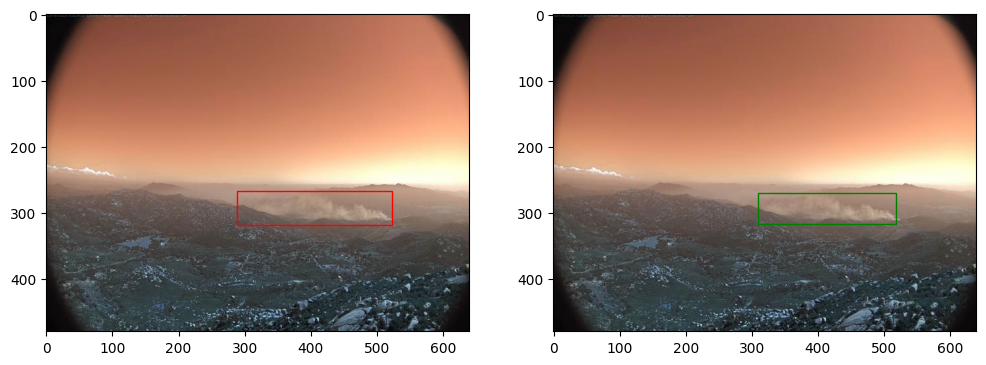

Prediction structure: <class 'dict'> {'boxes': tensor([[490.8358, 213.5148, 614.6032, 286.9804]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9984], device='cuda:0')}


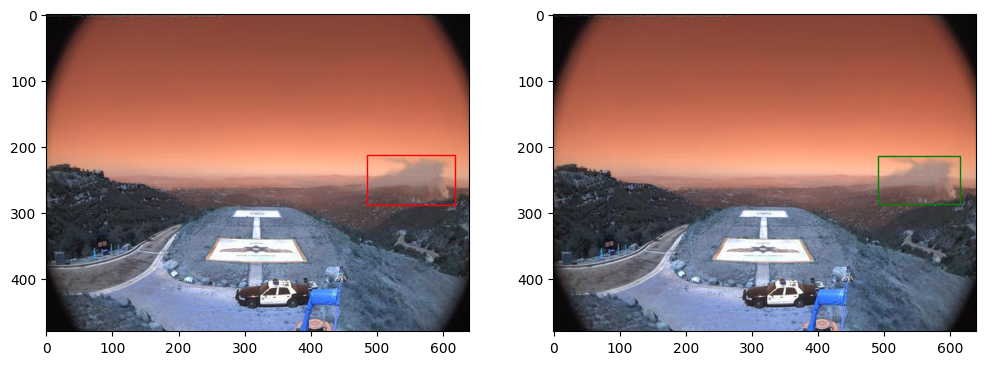

Prediction structure: <class 'dict'> {'boxes': tensor([[327.2275, 225.3865, 410.7860, 253.5074]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9988], device='cuda:0')}


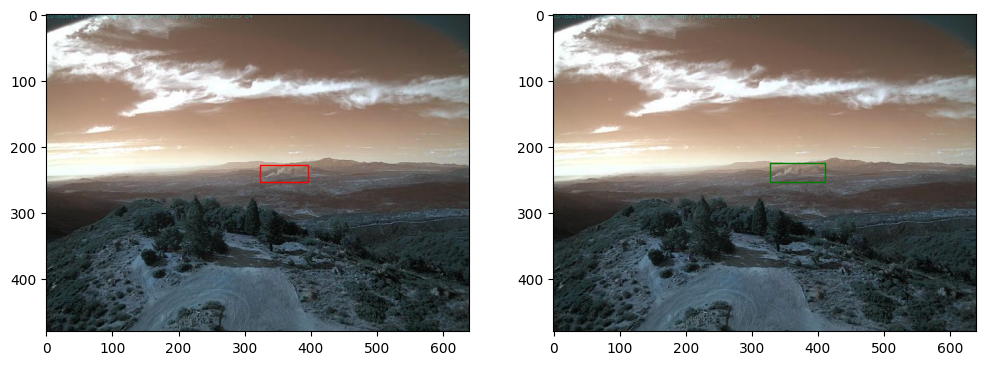

Prediction structure: <class 'dict'> {'boxes': tensor([[ 84.7312, 231.5364, 278.2433, 288.8352],
        [ 81.6352, 239.4734, 149.6742, 273.5416]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9988, 0.6066], device='cuda:0')}


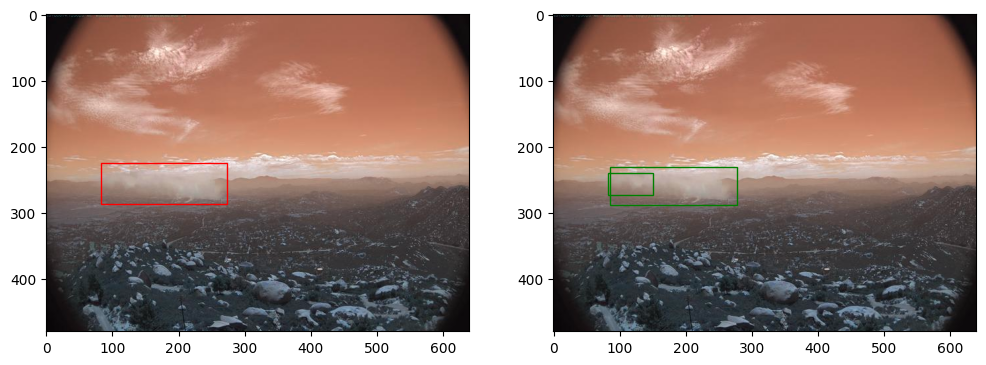

Prediction structure: <class 'dict'> {'boxes': tensor([[129.1673, 214.3942, 176.7210, 285.7300]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9953], device='cuda:0')}


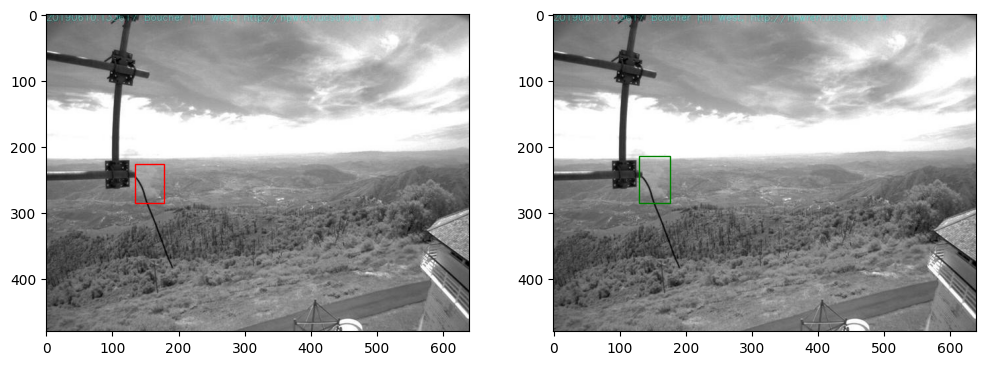

Precision: 0.6666666666666666, Recall: 1.0, Mean IoU: 0.6226929082191205


In [ ]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

def bbox_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    """
    b1_x1, b1_y1, b1_x2, b1_y2 = box1
    b2_x1, b2_y1, b2_x2, b2_y2 = box2

    # Get the coordinates of the intersection rectangle
    inter_rect_x1 = max(b1_x1, b2_x1)
    inter_rect_y1 = max(b1_y1, b2_y1)
    inter_rect_x2 = min(b1_x2, b2_x2)
    inter_rect_y2 = min(b1_y2, b2_y2)

    # Intersection area
    inter_area = max(inter_rect_x2 - inter_rect_x1, 0) * max(inter_rect_y2 - inter_rect_y1, 0)

    # Union Area
    b1_area = (b1_x2 - b1_x1) * (b1_y2 - b1_y1)
    b2_area = (b2_x2 - b2_x1) * (b2_y2 - b2_y1)
    union_area = b1_area + b2_area - inter_area

    # Calculate IoU
    iou = inter_area / union_area if union_area else 0
    return iou

def visualize_prediction(image, target, prediction):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image)
    ax[1].imshow(image)

    # Draw ground truth boxes
    for box in target['boxes']:
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none')
        ax[0].add_patch(rect)

    # Debugging and handling various prediction structures
    if prediction:
        print("Prediction structure:", type(prediction), prediction)  # Inspect prediction structure

        if isinstance(prediction, dict) and 'boxes' in prediction:
            prediction_boxes = prediction['boxes']
        elif isinstance(prediction, list) and len(prediction) > 0 and isinstance(prediction[0], dict) and 'boxes' in prediction[0]:
            prediction_boxes = prediction[0]['boxes']
        else:
            print("Unexpected prediction structure")
            return

        for box in prediction_boxes.cpu().numpy():
            rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='g', facecolor='none')
            ax[1].add_patch(rect)
    else:
        print("No valid predictions to visualize")

    plt.show()

def evaluate_and_visualize_model(test_data_loader, model, device, iou_threshold=0.5, num_visualizations=5):
    model.eval()
    all_iou = []
    true_positives = 0
    total_predictions = 0
    total_ground_truths = 0
    visualization_count = 0

    with torch.no_grad():
        for images, targets in test_data_loader:
            images = list(img.to(device) for img in images)
            batch_predictions = model(images)

            for image, target, prediction in zip(images, targets, batch_predictions):
                # Visualization logic
                if visualization_count < num_visualizations:
                    image_np = image.mul(255).permute(1, 2, 0).byte().cpu().numpy()
                    image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
                    visualize_prediction(image_np, target, prediction)
                    visualization_count += 1

                # Check the structure of prediction and extract boxes
                if isinstance(prediction, dict) and 'boxes' in prediction:
                    pred_boxes = prediction['boxes']
                elif isinstance(prediction, list) and len(prediction) > 0 and isinstance(prediction[0], dict) and 'boxes' in prediction[0]:
                    pred_boxes = prediction[0]['boxes']
                else:
                    print("Unexpected prediction structure:", prediction)
                    continue  # Skip to the next iteration

                # Process each predicted box
                for pred_box in pred_boxes:
                    pred_box = pred_box.cpu().numpy()
                    highest_iou = 0
                    for gt_box in target['boxes']:
                        gt_box = gt_box.cpu().numpy()
                        iou = bbox_iou(pred_box, gt_box)
                        highest_iou = max(highest_iou, iou)

                    if highest_iou >= iou_threshold:
                        true_positives += 1
                    all_iou.append(highest_iou)

                total_predictions += len(pred_boxes)
                total_ground_truths += len(target['boxes'])

    precision = true_positives / total_predictions if total_predictions else 0
    recall = true_positives / total_ground_truths if total_ground_truths else 0
    mean_iou = sum(all_iou) / len(all_iou) if all_iou else 0

    return precision, recall, mean_iou

# Assuming CustomDataset, custom_collate_fn, model, device, and test_data_loader are defined elsewhere
# Evaluate the model and visualize predictions
precision, recall, mean_iou = evaluate_and_visualize_model(test_data_loader, model, device)
print(f"Precision: {precision}, Recall: {recall}, Mean IoU: {mean_iou}")


In [ ]:

print(f"Precision: {precision}, Recall: {recall}, Mean IoU: {mean_iou}")


Precision: 0.6666666666666666, Recall: 1.0, Mean IoU: 0.6226929082191205
